# Trabalho de Inteligência Artificial 2 - IESB

## Classificação de Sentimento em Twitters sobre os candidatos a presidência do Brasil - 2018

Este trabalho tem como objetivo analizar os sentimentos de twitters realizados sobre os candidatos a presidência do Brasil em 2018 entre textos com mensagens positivas ou negativas, e exemplificar em gráficos as analizes dos mesmos de forma individual.

### Candidatos a presidência 2018

+ Jair Bolsonaro (PSL) – 17
+ Fernando Haddad (PT) – 13
+ Ciro Gomes (PDT) – 12
+ Geraldo Alckmin (PSDB) – 45
+ Marina Silva (Rede) – 18
+ Alvaro Dias (Podemos) – 19
+ Henrique Meirelles (MDB) – 15
+ João Amoêdo (Novo) – 30
+ Guilherme Boulos (PSOL) – 50
+ José Maria Eymael (Democracia Cristã) – 27
+ Cabo Daciolo (Patriota) – 51
+ João Goulart Filho (PPL) – 54
+ Vera Lucia (PSTU) – 16

# Bibliotecas utilizadas no projeto

In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler, Stream
import time
from pprint import pprint
import json

import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd

import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import re
import nltk
from nltk.corpus import stopwords 
from nltk.stem.lancaster import LancasterStemmer

from googletrans import Translator
import os

C:\Users\Allan\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
nltk.download('stopwords')
nltk.download('steaming')

#  Web Crawler

Utilizando a biblioteca [Tweepy] [link1] e a autorização do Twitter para utilizar sua [API] [link2], foi realizado um web crawler, buscando localizar 1000 com os termos listados abaixo. O tempo de execução de cada busca está listado abaixo de cada termo.

O processador utilizado foi um Intel(R) Core(TM) i5-6200U CPU @ 2.30GHz 2.40 GHz.

#### Termos:

+ 'Bolsonaro'
    * inicio: 1539456861.4597087
    * fim: 1539456958.9965942
    * total: 97.53688549995422
+ 'Haddad'
    * inicio: 1539456613.1283784
    * fim:    1539456791.6778507
    * total:  178.54947233200073
+ 'Ciro'
    * inicio: 1539456323.9065177
    * fim: 1539458030.606718
    * total: 1706.7002003192902
+ 'Alckmin'
    * inicio: 1539458055.8657103
    * fim: 1539461812.2720942
    * total: 3756.4063839912415
+ 'Marina Silva'
+ 'Alvaro Dias'
+ 'Meirelles'
+ 'Amoêdo'
+ 'Boulos'
    * inicio: 1539462744.8071775
    * fim: 1539465263.4699695
    * total: 2518.662791967392
+ 'Eymael'
+ 'Daciolo'
+ 'Goulart'
+ 'Vera Lucia'

##### OBS: O código utilizado para realizar o crawler está localizado abaixo

[link1]: https://github.com/tweepy/tweepy
[link2]: https://developer.twitter.com

In [3]:
"""
# Variaveis de permição concedidas pelo Twitter à desenvolvedores
access_token = "" 
access_token_secret = ""
consumer_key = ""
consumer_secret = ""

# Termo que será crawleado
candidato = ""

# Classe que herda de StreamListener para realizar o Crawler
class StdoutListener(StreamListener):
	raw_data = {'text':[], 'candidato':[]}
	def on_data(self, data):
		try:
            # Cria duas colunas no dataset: Text e Candidato
			self.raw_data['text'].append(json.loads(data)['text'])
			self.raw_data['candidato'].append(candidato)
            # Caso já tenham sido capturadas 10000 twitters, o csv é salvo no diretorio indicado
			if len(self.raw_data['text']) == 1000:
				pprint(self.raw_data)
				df = pd.DataFrame(self.raw_data, columns = ['candidato', 'text'])
				df.to_csv(candidato+'.csv')
			return True
		except BaseException as e:
			print(str(e))
			time.sleep(5)

	def on_error(self, status):
		print(status)

if __name__ == "__main__":
	twiteer = StdoutListener() # Instância do Objeto
    # Inserindo credênciais de autorização
	auth = OAuthHandler(consumer_key, consumer_secret) 
	auth.set_access_token(access_token, access_token_secret)
	stream = Stream(auth, twiteer) # Instânciando objeto de crawler
	stream.filter(track=[candidato]) # Definindo termo que será utilizado para pesquisa
    """

'\n# Variaveis de permição concedidas pelo Twitter à desenvolvedores\naccess_token = "" \naccess_token_secret = ""\nconsumer_key = ""\nconsumer_secret = ""\n\n# Termo que será crawleado\ncandidato = ""\n\n# Classe que herda de StreamListener para realizar o Crawler\nclass StdoutListener(StreamListener):\n\traw_data = {\'text\':[], \'candidato\':[]}\n\tdef on_data(self, data):\n\t\ttry:\n            # Cria duas colunas no dataset: Text e Candidato\n\t\t\tself.raw_data[\'text\'].append(json.loads(data)[\'text\'])\n\t\t\tself.raw_data[\'candidato\'].append(candidato)\n            # Caso já tenham sido capturadas 10000 twitters, o csv é salvo no diretorio indicado\n\t\t\tif len(self.raw_data[\'text\']) == 1000:\n\t\t\t\tpprint(self.raw_data)\n\t\t\t\tdf = pd.DataFrame(self.raw_data, columns = [\'candidato\', \'text\'])\n\t\t\t\tdf.to_csv(candidato+\'.csv\')\n\t\t\treturn True\n\t\texcept BaseException as e:\n\t\t\tprint(str(e))\n\t\t\ttime.sleep(5)\n\n\tdef on_error(self, status):\n\t\tpri

# Leitura do dataset

Utilizando o dataset disponivel [neste link] [link1], que possui 99989 twitters, tentamos realizar o treinamento de nossa rede neural.

O dataset possui três colunas: 

#### Colunas:

+ 'ItemID'
    * Representa o id da linha. Este foi retirado no momento de leitura
+ 'Sentiment'
    * Este define o sentimento do twitter entre 0(NEGATIVO) ou 1(POSITIVO)
+ 'SentimentText'
    * Aqui encontra-se o texto do twitter em si
    
|ItemID|Sentiment|SentimentText|
|------|------|------|
|1  |0  |text  |
|2  |1  |text  | 
|3  |0  |text  | 
|...  |...  |...  | 

[link1]: https://www.kaggle.com/c/twitter-sentiment-analysis2

In [4]:
import pandas as pd
data = pd.read_csv('train.csv', encoding='latin-1')
data = data.drop(['ItemID'], axis=1)
data.head()

,Sentiment,SentimentText
0,0,is so sad for my APL frie...
1,0,I missed the New Moon trail...
2,1,omg its already 7:30 :O
3,0,.. Omgaga. Im sooo im gunna CRy. I'...
4,0,i think mi bf is cheating on me!!! ...


In [5]:
data.Sentiment.value_counts()

1    56457
0    43532
Name: Sentiment, dtype: int64

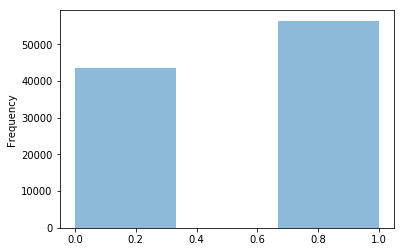

In [6]:
data.Sentiment.plot.hist(bins=3, alpha=0.5)

In [7]:
data.shape

(99989, 2)

In [8]:
print('Total de textos a serem analizados:', data.SentimentText.value_counts().size)
print('Total de termos sem repetição:', data.SentimentText.unique().size)

Total de textos a serem analizados: 99989
Total de termos sem repetição: 99989


# Tratamento dos dados

Nesta etapa utilizaremos as bibliotecas re e nltk do python para tratar nossos dados antes de utiliza-los em nossa rede neural, seguindo diversas etapas afim de melhorar nossa acurácia.

Ápos o tratamento realizaremos a tokenização de nossos twitters com keras, transformando-os em valores numericos, para efetivamente serem jogados na rede neural.

#### Etapas de tratamento:

+ Palavras com caracteres minusculos
+ Remoções:
    * Pontuação
    * Caracteres repetidos
    * StopWords
    * Nomes próprios
    * Valores numericos
    * Links, emails e URLs
    * Usernames
+ Tokenization
+ Steamization ou Lammetization
+ Concatenação

In [9]:
def words_to_lower(data):
    return data.SentimentText.apply(lambda x: x.lower())

def remove_username(data):
    return data.SentimentText.apply(lambda x: re.sub(r'@[\w\.-]+','',x))

def remove_email(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[\w\.-]+@[\w\.-]+','',x))

def remove_url(data):
    return data.SentimentText.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*','',x))

def remove_number(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[0-9]','',x))

def remove_pontuation(data):
    return data.SentimentText.apply(lambda x: re.sub(r'[^a-zA-z\s]','',x))

def remove_repeated_character(data):
    return data.SentimentText.apply(lambda x: re.sub(r"(\w)\1*", r'\1', x))

def tokenizing(data):
    return data.SentimentText.apply(lambda x: nltk.word_tokenize(x))

def remove_stopword(data):
    stop_words = set(stopwords.words('english'))
    return data.SentimentText.apply(lambda x: [j for j in x if not j in stop_words])

def stemming(data):
    stem = LancasterStemmer()
    return data.SentimentText.apply(lambda x: [stem.stem(j) for j in x])

def concat(data):
    return data.SentimentText.apply(lambda x: " ".join(x))

In [10]:
data.SentimentText = words_to_lower(data)
data.SentimentText = remove_username(data)
data.SentimentText = remove_number(data)
data.SentimentText = remove_pontuation(data)
data.SentimentText = remove_repeated_character(data)
data.SentimentText = tokenizing(data)
data.SentimentText = remove_stopword(data)
data.SentimentText = stemming(data)
data.SentimentText = concat(data)

In [11]:
data.head()

,Sentiment,SentimentText
0,0,sad apl friend
1,0,mis new mon trail
2,1,omg already
3,0,omgag im im gun cry iv ben dent sint supos get...
4,0,think mi bf che t_t


# Treinamento

Nesta etapa será realizado o treinamento do modelo. Para isso alguns passos devem ser seguidos:

#### Etapas de treinamento:

+ Tokenização dos Textos e Labels
+ Criação do modelo de treino
    * Embedding -->> Mapeadas para vetores de números reais
    * LSTM(Long short-term memory) -->> Unidades de uma rede neural recorrente
    * Dense(Softmax) -->> Layer para que a saída esteja com valores entre 0-1
+ Split dos dados em treino e teste
+ Treinamento

In [13]:
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data.SentimentText.values)
X = tokenizer.texts_to_sequences(data.SentimentText.values)
X = pad_sequences(X)

In [14]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = X.shape[1]))
model.add(SpatialDropout1D(0.4))
model.add(LSTM(lstm_out, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2,activation='softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 128)           256000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 53, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 394       
Total params: 511,194
Trainable params: 511,194
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
Y = pd.get_dummies(data['Sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.33, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(66992, 53) (66992, 2)
(32997, 53) (32997, 2)


In [17]:
batch_size = 32
history = model.fit(X_train, Y_train, epochs = 20, batch_size=batch_size, verbose = 1)

Epoch 1/20
66992/66992 [==============================] - 275s 4ms/step - loss: 0.5108 - acc: 0.7460
Epoch 2/20
66992/66992 [==============================] - 261s 4ms/step - loss: 0.4919 - acc: 0.7582
Epoch 3/20
66992/66992 [==============================] - 249s 4ms/step - loss: 0.4792 - acc: 0.7660
Epoch 4/20
66992/66992 [==============================] - 250s 4ms/step - loss: 0.4679 - acc: 0.7708
Epoch 5/20
66992/66992 [==============================] - 250s 4ms/step - loss: 0.4578 - acc: 0.7793
Epoch 6/20
66992/66992 [==============================] - 251s 4ms/step - loss: 0.4486 - acc: 0.7843
Epoch 7/20
66992/66992 [==============================] - 250s 4ms/step - loss: 0.4374 - acc: 0.7908
Epoch 8/20
66992/66992 [==============================] - 251s 4ms/step - loss: 0.4273 - acc: 0.7964
Epoch 9/20
66992/66992 [==============================] - 252s 4ms/step - loss: 0.4150 - acc: 0.8024
Epoch 10/20
66992/66992 [==============================] - 251s 4ms/step - loss: 0.4046 - a

In [ ]:
model.save('twitter_sentimental_analyze.h5')

# Analise do modelo de treino

Após a etapa de treino, iremos validar o modelo para verificar se este apresenta bons resultados para dados que não estavam presentes no dataset de treino. 

#### Etapas de analise:

+ Analise do historico
+ Validação do score
+ Matriz de confusão

In [18]:
def plt_history(name, color, index):
    plt.figure()
    plt.title('Model '+name)
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.plot(history.epoch, np.array(history.history[index]), color=color)

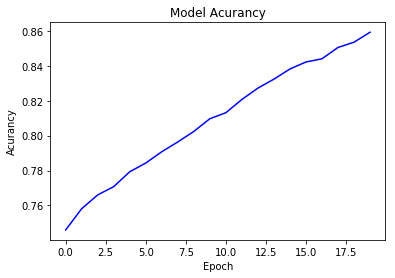

In [19]:
plt_history("Acurancy", "blue", "acc")

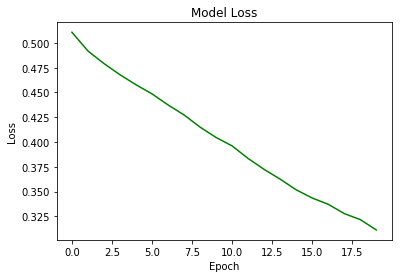

In [20]:
plt_history("Loss", "green", "loss")

In [22]:
validation_size = 1500

X_validate = X_test[-validation_size:]
Y_validate = Y_test[-validation_size:]
X_test = X_test[:-validation_size]
Y_test = Y_test[:-validation_size]
score,acc = model.evaluate(X_test, Y_test, verbose = 2, batch_size = batch_size)
print("score: %.2f" % (score))
print("acc: %.2f" % (acc))

score: 0.73
acc: 0.72


In [23]:
predicted = model.predict(X_test)
predict = list()
test_labels = list()
for value in predicted:
    predict.append(0 if value[0] < value[1] else 1)
for value in Y_test:
    test_labels.append(0 if value[0] < value[1] else 1)

In [24]:
Y_test

array([[0, 1],
       [0, 1],
       [1, 0],
       ...,
       [0, 1],
       [1, 0],
       [0, 1]], dtype=uint8)

[[13465  4195]
 [ 4518  9319]]


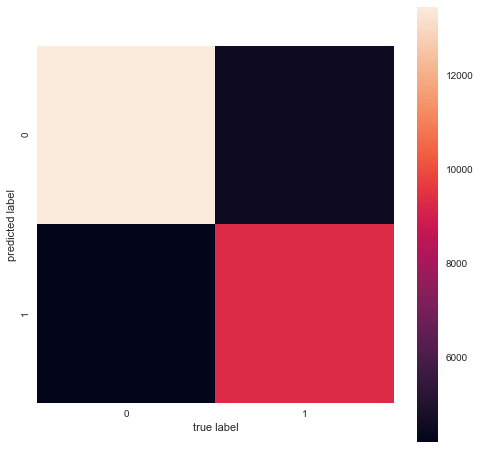

In [25]:
%matplotlib inline
mat = confusion_matrix(test_labels, predict)
plt.figure(figsize=(8, 8))
sns.set()
sns.heatmap(mat.T, square=True,
            xticklabels=np.unique(test_labels),
            yticklabels=np.unique(test_labels))
# annot=True,
plt.xlabel('true label')
plt.ylabel('predicted label')
# Save confusion matrix to outputs in Workbench
# plt.savefig(os.path.join('.', 'outputs', 'confusion_matrix.png'))
print(mat)
plt.show()

# Tratando mensagens crawleadas

Após a etapa de treino, iremos validar o modelo para verificar se este apresenta bons resultados para dados que não estavam presentes no dataset de treino. 

#### Etapas de analise:

+ Validação do score
+ Matriz de confusão

In [28]:
def words_to_lower(data):
    return data.Text.apply(lambda x: x.lower())

def remove_username(data):
    return data.Text.apply(lambda x: re.sub(r'@[\w\.-]+','',x))

def remove_email(data):
    return data.Text.apply(lambda x: re.sub(r'[\w\.-]+@[\w\.-]+','',x))

def remove_url(data):
    return data.Text.apply(lambda x: re.sub(r'^https?:\/\/.*[\r\n]*','',x))

def remove_number(data):
    return data.Text.apply(lambda x: re.sub(r'[0-9]','',x))

def remove_pontuation(data):
    return data.Text.apply(lambda x: re.sub(r'[^a-zA-z\s]','',x))

def remove_repeated_character(data):
    return data.Text.apply(lambda x: re.sub(r"(\w)\1*", r'\1', x))

def tokenizing(data):
    return data.Text.apply(lambda x: nltk.word_tokenize(x))

def remove_stopword(data):
    stop_words = set(stopwords.words('english'))
    return data.Text.apply(lambda x: [j for j in x if not j in stop_words or j is "rt"])

def stemming(data):
    stem = LancasterStemmer()
    return data.Text.apply(lambda x: [stem.stem(j) for j in x])

def concat(data):
    return data.Text.apply(lambda x: " ".join(x))

def translating(data):
    translator = Translator()
    return data.Text.apply(lambda x: translator.translate(x).text,x)

In [35]:
def analyzis(data):
    predict = list()
    for d in data.Text.values:
        twt = d
        twt = tokenizer.texts_to_sequences(twt)
        twt = pad_sequences(twt, maxlen=53, dtype='int32', value=0)
        sentiment = model.predict(twt,batch_size=1,verbose = 2)[0]
        if(np.argmax(sentiment) == 0):
            predict.append(0)
        elif (np.argmax(sentiment) == 1):
            predict.append(1)
    return predict

# Analises dos Twitters

### Analise de Sentimento : Bolsonaro

In [30]:
data = pd.read_csv("Candidatos/Bolsonaro.csv", names=['Candidato', 'Text'])
data.head()

,Candidato,Text
NaN,candidato,text
0.0,Bolsonaro,RT @Miltonneves: Falo como “sapo de fora”. Ess...
1.0,Bolsonaro,RT @cidadaodemal: Viva Nossa Senhora Aparecida...
2.0,Bolsonaro,RT @carloscezarcjr: Bolsonaro fica em 1° lugar...
3.0,Bolsonaro,"RT @NaoInviabilize: não foi atacada, não foi a..."


In [31]:
data.Text = words_to_lower(data)
data.Text = remove_username(data)
data.Text = remove_number(data)
data.Text = remove_pontuation(data)
data.Text = remove_repeated_character(data)
data.Text = translating(data)
data.Text = tokenizing(data)
data.Text = remove_stopword(data)
data.Text = stemming(data)
data.Text = concat(data)

In [36]:
p = analyzis(data)

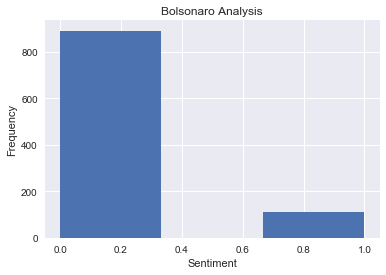

In [37]:
plt.hist(p, bins=3, align=('mid'))
plt.title("Bolsonaro Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

### Analise de Sentimento : Haddad

In [38]:
data = pd.read_csv("Candidatos/Haddad.csv", names=['Candidato', 'Text'])
data.head()

,Candidato,Text
NaN,candidato,text
0.0,Haddad,"RT @Desesquerdizada: 1° turno, Bolsonaro receb..."
1.0,Haddad,@Haddad_Fernando o que o senhor explica?
2.0,Haddad,@gorilagato Vi uma moça andando com uma camise...
3.0,Haddad,"RT @NaoInviabilize: não foi atacada, não foi a..."


In [39]:
data.Text = words_to_lower(data)
data.Text = remove_username(data)
data.Text = remove_number(data)
data.Text = remove_pontuation(data)
data.Text = remove_repeated_character(data)
data.Text = translating(data)
data.Text = tokenizing(data)
data.Text = remove_stopword(data)
data.Text = stemming(data)
data.Text = concat(data)

In [40]:
p = analyzis(data)

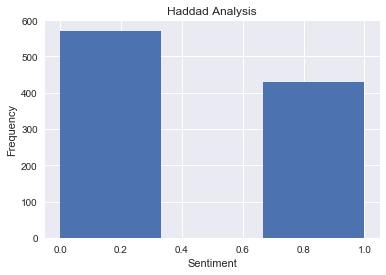

In [58]:
plt.hist(p, bins=3, align=('mid'))
plt.title("Haddad Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

### Analise de Sentimento : Ciro

In [42]:
data = pd.read_csv("Candidatos/Ciro.csv", names=['Candidato', 'Text'])
data.head()

,Candidato,Text
NaN,candidato,text
0.0,Ciro,@brokiado Se fosse o Ciro já tinha chamado de ...
1.0,Ciro,Só me resta lamentar https://t.co/oJwDxBAaIG
2.0,Ciro,RT @DaniloGentili: Começou falando que ia tira...
3.0,Ciro,FORO 12 MÍDIA PETISTA 247 JOGA A TOALHA E ATA...


In [59]:
data.Text = words_to_lower(data)
data.Text = remove_username(data)
data.Text = remove_number(data)
data.Text = remove_pontuation(data)
data.Text = remove_repeated_character(data)
data.Text = translating(data)
data.Text = tokenizing(data)
data.Text = remove_stopword(data)
data.Text = stemming(data)
data.Text = concat(data)

In [60]:
p = analyzis(data)

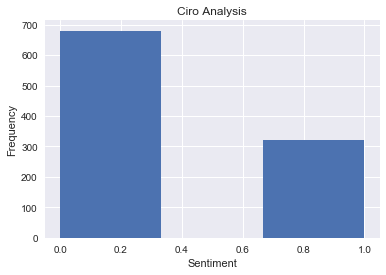

In [86]:
plt.hist(p, bins=3, align=('mid'))
plt.title("Ciro Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

### Analise de Sentimento : Alckmin

In [65]:
data = pd.read_csv("Candidatos/Alckmin.csv", names=['Candidato', 'Text'])
data.head()

,Candidato,Text
NaN,candidato,text
0.0,Alckmin,RT @zehdeabreu: Respeitei a posição de @regina...
1.0,Alckmin,RT @EISENHOWER27: Eleitores e simpatizantes do...
2.0,Alckmin,RT @zehdeabreu: Respeitei a posição de @regina...
3.0,Alckmin,RT @EISENHOWER27: Eleitores e simpatizantes do...


In [66]:
data.Text = words_to_lower(data)
data.Text = remove_username(data)
data.Text = remove_number(data)
data.Text = remove_pontuation(data)
data.Text = remove_repeated_character(data)
data.Text = translating(data)
data.Text = tokenizing(data)
data.Text = remove_stopword(data)
data.Text = stemming(data)
data.Text = concat(data)

In [74]:
p = analyzis(data)

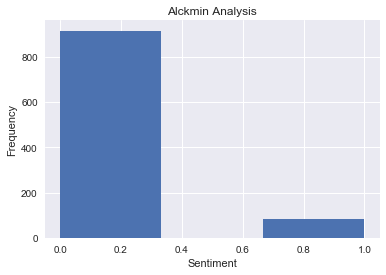

In [88]:
plt.hist(p, bins=3, align=('mid'))
plt.title("Alckmin Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()

### Analise de Sentimento : Boulos

In [69]:
data = pd.read_csv("Candidatos/Boulos.csv", names=['Candidato', 'Text'])
data.head()

,Candidato,Text
NaN,candidato,text
0.0,Boulos,RT @Mestredestra1: PT de Verde e Amarelo\r\nMa...
1.0,Boulos,RT @analisdocsPF: BOULOS QUER INVADIR A CASA D...
2.0,Boulos,RT @esquerdanao: Boulos convoca apoiadores par...
3.0,Boulos,"RT @Fabi_Moller_: Boulos ""É lamentável que Bol..."


In [70]:
data.Text = words_to_lower(data)
data.Text = remove_username(data)
data.Text = remove_number(data)
data.Text = remove_pontuation(data)
data.Text = remove_repeated_character(data)
data.Text = translating(data)
data.Text = tokenizing(data)
data.Text = remove_stopword(data)
data.Text = stemming(data)
data.Text = concat(data)

In [71]:
p = analyzis(data)

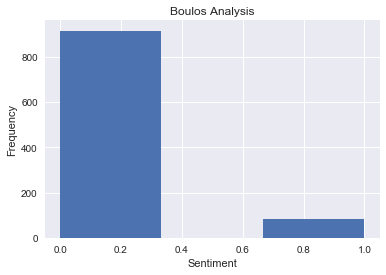

In [76]:
plt.hist(p, bins=3, align=('mid'))
plt.title("Boulos Analysis")
plt.xlabel("Sentiment")
plt.ylabel("Frequency")
plt.show()